In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow import keras as keras
from matplotlib import pyplot as plt

from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Activation, Input, Dense, Dropout, Flatten, Conv1D, MaxPooling1D, Reshape, Concatenate, concatenate

### 数据处理

In [30]:
# 读取数据
data_ini = pd.read_excel('data/TJ POLTS.xlsx')

data = data_ini.iloc[:,[1,3,4,5,6,7,8]]
data.head()

,AQI,PM2.5,PM10,NO2,SO2,CO,O3_8h
0,310,260,420,139,201,3.5,13
1,225,175,271,111,143,3.2,31
2,275,225,360,128,197,3.9,12
3,126,96,183,70,101,2.3,26
4,116,88,159,70,114,1.6,16


In [31]:
# 指数平滑
def expPreprocessing(df, alpha=0.05):
    edata = df.ewm(alpha=alpha, adjust=False).mean()
    return edata

alpha = 0.05
data_exp = expPreprocessing(data, alpha)
data_exp.head()

# alpha = 0.05
# data_exp = data.ewm(alpha=alpha, adjust=False).mean()
# data_exp.head()

,AQI,PM2.5,PM10,NO2,SO2,CO,O3_8h
0,310.000000,260.000000,420.000000,139.0000,201.000000,3.500000,13.000000
1,305.750000,255.750000,412.550000,137.6000,198.100000,3.485000,13.900000
2,304.212500,254.212500,409.922500,137.1200,198.045000,3.505750,13.805000
3,295.301875,246.301875,398.576375,133.7640,193.192750,3.445462,14.414750
4,286.336781,238.386781,386.597556,130.5758,189.233112,3.353189,14.494013


In [32]:
# 归一化
min_value = data_exp.min(axis=0)  
max_value = data_exp.max(axis=0)

data_std = (data_exp - min_value) / (max_value - min_value)

In [33]:
# 划分训练集与验证集

time_stamp = 50  # 时间点长度
ratio = 0.8

split = int(ratio*len(data))
train_data = data_std[0:split + time_stamp]
valid_data = data_std[split - time_stamp:]

In [34]:
label_column = 0 # 标签所在的列id
x_train, y_train = [], []
scaled_data = train_data.values
# 训练集
for i in range(time_stamp, len(train_data)):
    x_train.append(scaled_data[i - time_stamp:i])
    y_train.append(scaled_data[i, label_column])

x_train, y_train = np.array(x_train), np.array(y_train)


# 验证集
x_valid, y_valid = [], []
scaled_data = valid_data.values
for i in range(time_stamp, len(valid_data)):
    x_valid.append(scaled_data[i - time_stamp:i])
    y_valid.append(scaled_data[i, label_column])
    
x_valid, y_valid = np.array(x_valid), np.array(y_valid)

### 贝叶斯参数优化

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import optuna
def InformerBlock(input_layer, head_size, num_heads, ff_dim, dropout_rate):
    # 概率稀疏自注意力层 (这里简化为普通的多头注意力)
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout_rate)(input_layer, input_layer)
    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output + input_layer)

    # 前馈网络
    ffn_output = Dense(ff_dim, activation="relu")(attention_output)
    ffn_output = Dense(input_layer.shape[-1])(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    ffn_output = LayerNormalization(epsilon=1e-6)(ffn_output + attention_output)

    return ffn_output

def informer_model(input_shape, head_size, num_heads, ff_dim, num_blocks, dropout_rate):
    inputs = Input(shape=input_shape)
    x = inputs

    # Informer块
    for _ in range(num_blocks):
        x = InformerBlock(x, head_size, num_heads, ff_dim, dropout_rate)

    # 输出层
    x = Flatten()(x)
    outputs = Dense(1)(x)  # 假设目标是预测一个数值
    return Model(inputs, outputs)

class Trainer:
    def __init__(self, x_train, y_train, x_valid, y_valid, epochs=50, batch_size=64, n_trials=100):
        self.x_train, self.y_train, self.x_valid, self.y_valid = x_train, y_train, x_valid, y_valid
        self.epochs = epochs
        self.batch_size = batch_size
        self.n_trials = n_trials
    def objective(self, trial):
        lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
        head_size = trial.suggest_categorical('head_size', [32, 64, 128])
        num_heads = trial.suggest_int('num_heads', 1, 4)
        ff_dim = trial.suggest_int('ff_dim', 32, 128)
        num_blocks = trial.suggest_int('num_blocks', 1, 4)
        dropout_rate = trial.suggest_uniform('dropout_rate', 0., 0.5)

        model = informer_model(self.x_train.shape[1:], head_size, num_heads, ff_dim, num_blocks, dropout_rate)
        optimizer = Adam(learning_rate=lr)
        model.compile(loss='mean_squared_error', optimizer=optimizer)
        model.fit(self.x_train, self.y_train, epochs=self.epochs, batch_size=self.batch_size, verbose=0)

        y_pred = model.predict(self.x_valid)
        score = mean_squared_error(self.y_valid, y_pred)

        return score

    def optimizer_optuna(self):
        sampler = optuna.samplers.TPESampler()
        study = optuna.create_study(sampler=sampler, direction='minimize')
        study.optimize(self.objective, n_trials=self.n_trials, show_progress_bar=True)
        return study

In [36]:
# 超参数
epochs = 5
batch_size = 64
num_heads = 4
n_trials = 5
T = Trainer(x_train, y_train, x_valid, y_valid, epochs=epochs, batch_size=batch_size, n_trials=n_trials)
study = T.optimizer_optuna()
print(study.best_params)
print(study.best_value)

[I 2024-01-25 15:32:07,484] A new study created in memory with name: no-name-2050af47-6d4d-4ad0-986f-418762592da6
D:\anaconda3\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


[I 2024-01-25 15:32:12,715] Trial 0 finished with value: 0.0026914686466558133 and parameters: {'lr': 0.0012176477019903219, 'head_size': 32, 'num_heads': 2, 'ff_dim': 118, 'num_blocks': 2, 'dropout_rate': 0.4204865788724924}. Best is trial 0 with value: 0.0026914686466558133.
[I 2024-01-25 15:32:16,297] Trial 1 finished with value: 0.014317374308681062 and parameters: {'lr': 0.0011508957030447716, 'head_size': 128, 'num_heads': 1, 'ff_dim': 108, 'num_blocks': 1, 'dropout_rate': 0.47393964833191604}. Best is trial 0 with value: 0.0026914686466558133.
[I 2024-01-25 15:32:24,273] Trial 2 finished with value: 0.003521771230911369 and parameters: {'lr': 0.005016151782118052, 'head_size': 32, 'num_heads': 3, 'ff_dim': 110, 'num_blocks': 2, 'dropout_rate': 0.44109384956424397}. Best is trial 0 with value: 0.0026914686466558133.
[I 2024-01-25 15:32:34,051] Trial 3 finished with value: 0.009782277254746823 and parameters: {'lr': 0.006584430809416564, 'head_size': 128, 'num_heads': 4, 'ff_dim':

In [37]:
# 根据最优超参，训练和预测
params = study.best_params
lr = params['lr']
head_size = params['head_size']
num_heads = params['num_heads']
ff_dim = params['ff_dim']
num_blocks = params['num_blocks']
dropout_rate = params['dropout_rate']
checkpoint_path_best = "data/best.hdf5"
modelcheckpoint_best = keras.callbacks.ModelCheckpoint(checkpoint_path_best,
                                                       monitor='loss',
                                                       save_best_only=True,
                                                       mode='min',
                                                       verbose=0)
#LSTM

model = informer_model(x_train.shape[1:], head_size, num_heads, ff_dim, num_blocks, dropout_rate)

#print(model.summary())
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=lr))
model.fit(x_train, y_train, epochs=50, batch_size=batch_size, verbose=1, callbacks=[modelcheckpoint_best])

model.load_weights(checkpoint_path_best)
closing_price = model.predict(x_valid)

Epoch 1/50
41/41 [==============================] - 2s 22ms/step - loss: 0.2828
Epoch 2/50
41/41 [==============================] - 1s 21ms/step - loss: 0.1000
Epoch 3/50
41/41 [==============================] - 1s 21ms/step - loss: 0.0539
Epoch 4/50
41/41 [==============================] - 1s 21ms/step - loss: 0.0413
Epoch 5/50
41/41 [==============================] - 1s 21ms/step - loss: 0.0292
Epoch 6/50
41/41 [==============================] - 1s 21ms/step - loss: 0.0248
Epoch 7/50
41/41 [==============================] - 1s 21ms/step - loss: 0.0199
Epoch 8/50
41/41 [==============================] - 1s 21ms/step - loss: 0.0163
Epoch 9/50
41/41 [==============================] - 1s 21ms/step - loss: 0.0155
Epoch 10/50
41/41 [==============================] - 1s 21ms/step - loss: 0.0136
Epoch 11/50
41/41 [==============================] - 1s 21ms/step - loss: 0.0120
Epoch 12/50
41/41 [==============================] - 1s 21ms/step - loss: 0.0113
Epoch 13/50
41/41 [==================

In [38]:
# closing_price = scaler.inverse_transform(closing_price)
# y_valid = scaler.inverse_transform([y_valid])
y_valid_list = [y_valid]

mse_2 = mean_squared_error(y_valid_list[0], closing_price.reshape(1,-1)[0])
print("RMSE ", np.sqrt(mse_2))
mae = mean_absolute_error(y_valid_list[0], closing_price.reshape(1,-1)[0])
print("MAE ", mae)
r2 = r2_score(y_valid_list[0], closing_price.reshape(1,-1)[0])
print("R2SCORE ", r2)
mape = mean_absolute_percentage_error(y_valid_list[0], closing_price.reshape(1,-1)[0])
print("MAPE ", mape)

RMSE  0.028852305992472453
MAE  0.023632397395344378
R2SCORE  0.6448026845501997
MAPE  262602850454.55142


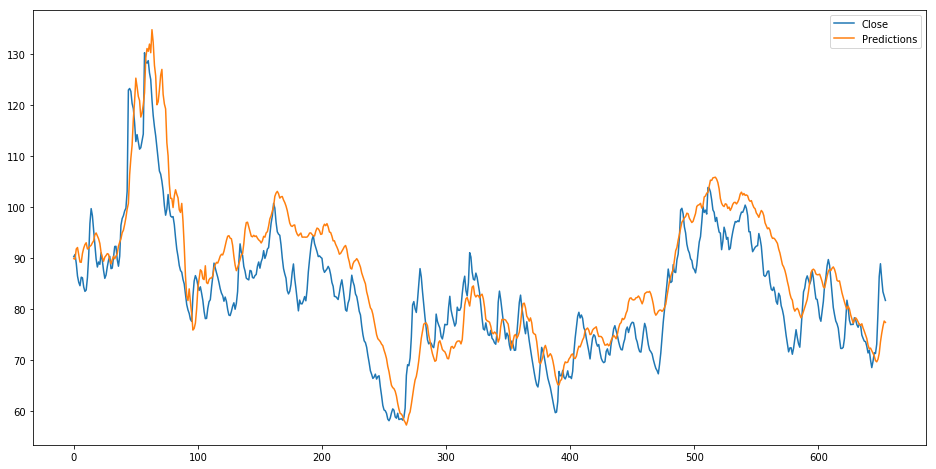

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 反归一化
closing_price_original = (closing_price.reshape(-1, 1) * (max_value[label_column] - min_value[label_column])) + min_value[label_column]
y_valid_original = (y_valid.reshape(-1, 1) * (max_value[label_column] - min_value[label_column])) + min_value[label_column]
# 创建图表
plt.figure(figsize=(16, 8))
dict_data = {
    'Predictions': closing_price_original.flatten(),
    'Close': y_valid_original.flatten()
}
data_pd = pd.DataFrame(dict_data)
plt.plot(data_pd[['Close', 'Predictions']])
plt.legend(['Close', 'Predictions'], loc='upper right')
plt.show()
# 保存预测值
pd.DataFrame(closing_price_original).to_csv('data/Informer_pred_TJ.csv', index=False)

In [40]:
# valid.iloc[time_stamp:,0].values == y_valid

train_labels = list(data.iloc[:split,0])   # data.iloc[split:,0]
test_labels = list(data.iloc[:,0])

prediction_values = closing_price.reshape(1,-1)[0]
prediction_exp = prediction_values * (max_value[0] - min_value[0]) + min_value[0]
prediction_list = list(prediction_exp)
all_labels = train_labels + prediction_list

labels_dict = {'prediction': all_labels, 'test': test_labels}
df_labels = pd.DataFrame(labels_dict)

In [41]:
df_labels

,prediction,test
0,310.000000,310
1,225.000000,225
2,275.000000,275
3,126.000000,126
4,116.000000,116
5,295.000000,295
6,248.000000,248
7,42.000000,42
8,109.000000,109
9,70.000000,70


In [42]:
def exp_reversed(df, alpha):
    row_0 = df.iloc[0]
    df_t_1 = df.iloc[:0].append(row_0, ignore_index=True).append(df.iloc[:-1], ignore_index=True)
    results = (df - (1-alpha)*df_t_1)/alpha
    results.iloc[0] = df.iloc[0]
    return results
    
original_labels = exp_reversed(df_labels, alpha)
original_labels

,prediction,test
0,310.000000,310.0
1,-1390.000000,-1390.0
2,1225.000000,1225.0
3,-2705.000000,-2705.0
4,-74.000000,-74.0
5,3696.000000,3696.0
6,-645.000000,-645.0
7,-3872.000000,-3872.0
8,1382.000000,1382.0
9,-671.000000,-671.0
